# Implementation of a comparison of Split and uncalibrated scenarion

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import multiprocessing as mp
from src.util import sigmoid
from src.feature_map import IdentityFeatureMap
from src.functions import cost_utility, demographic_parity
from src.plotting import plot_mean_over_time, plot_median_over_time, plot_mean_over_lambdas, plot_median_over_lambdas
from src.training import train
from src.distribution import SplitDistribution, UncalibratedScore

In [2]:
def fairness_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]
    numerator, denominator_log_grad = policy._log_gradient(x, s)

    benefit = policy.benefit_function(decisions=decisions, y=y)

    if ips_weights is not None:
        mu_s = np.mean(s * ips_weights, axis=0)
    else:
        mu_s = np.mean(s, axis=0)

    if ips_weights is not None:
        benefit *= ips_weights

    covariance = (s - mu_s) * benefit
    covariance_grad = (covariance * numerator)/denominator_log_grad

    return np.mean(covariance, axis=0) * np.mean(covariance_grad, axis=0)

## Uncalibrated Score

In [3]:
bias = True
dim_x = 1
dim_theta = dim_x + 1 if bias else dim_x

def util_func(**util_params):
    util = cost_utility(cost_factor=0.142, **util_params)
    return util

training_parameters = {    
    'model':{
        'theta': [-3.0, 5.0],
        'benefit_function': demographic_parity,
        'utility_function': util_func,
        'fairness_function': fairness_function,
        'feature_map': IdentityFeatureMap(dim_theta),
        'keep_collected_data': False,
        'use_sensitve_attributes': False,
        'bias': bias
    },
    'optimization': {
        'time_steps':200,
        'epochs': 1,
        'batch_size':256,
        'learning_rate': 1,
        'decay_rate': 1,
        'decay_step': 10000
    },
    'data': {
        'distribution': UncalibratedScore(bias=bias),
        'keep_data_across_lambdas': True,
        'fraction_protected':0.5,
        'num_test_samples': 8192,
        'num_decisions': 128 * 256
    }
}


--------------------------------------------------
------------------- Lambda 0.0 -------------------
--------------------------------------------------


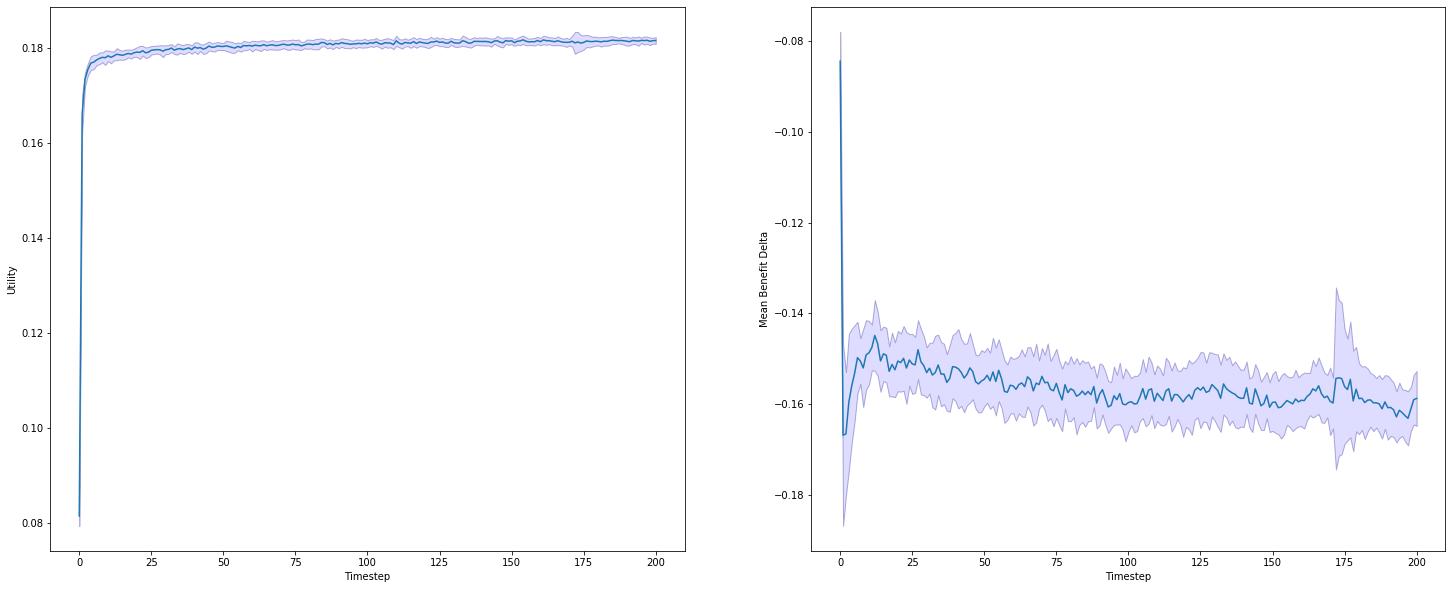

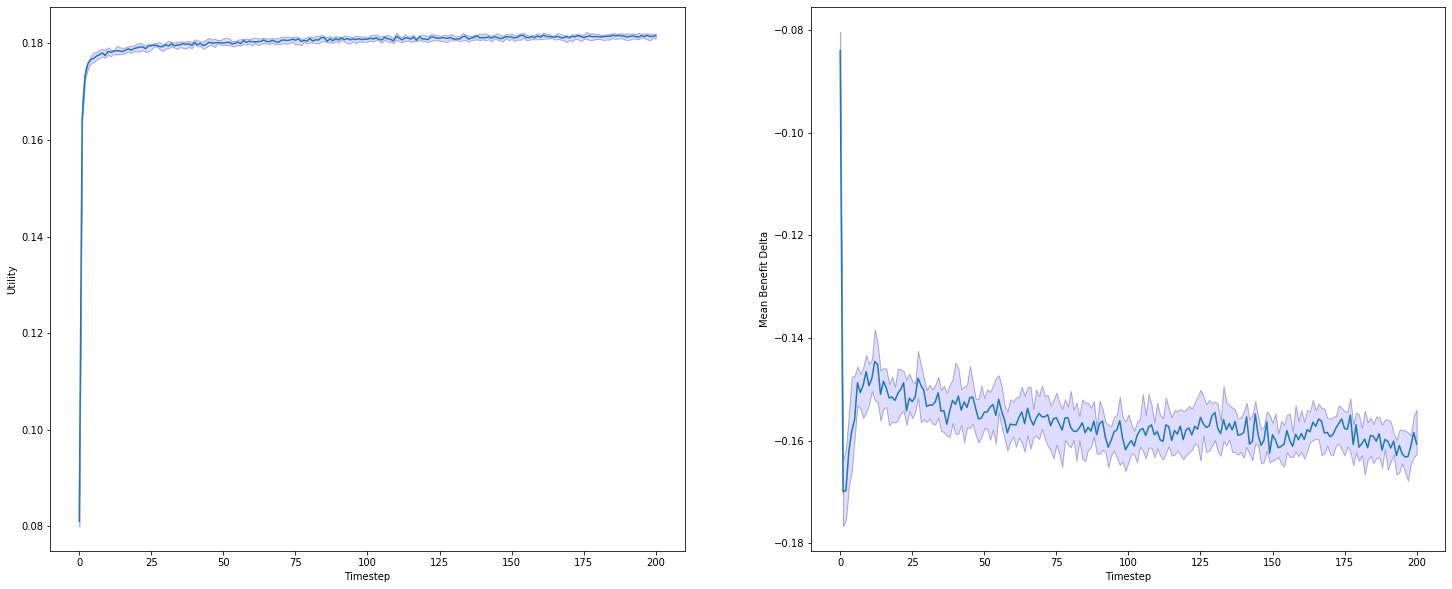

In [4]:
training_parameters["save_path"] = "/home/fkretschmar/Documents/master-thesis/res/exp-008/uncalibrated/time"
statistics, run_path = train(training_parameters, fairness_rates=[0.0], iterations=30, verbose=False, asynchronous=True)

plot_mean_over_time(statistics, "{}/results_mean_time.png".format(run_path))
plot_median_over_time(statistics, "{}/results_median_time.png".format(run_path))

--------------------------------------------------
------------------- Lambda 0.0 -------------------
--------------------------------------------------
------------------- Utility ----------------------
Mean: 0.17967013346354166
Standard deviation: 0.0009811045632702456
First quartile: 0.17891790771484375
Median: 0.1793668212890625
Last quartile: 0.18058129882812501
------------------- Benefit Delta ----------------
Mean: -0.16454682832488152
Standard deviation: 0.006185102330643956
First quartile: -0.16862025961770638
Median: -0.16518932501697092
Last quartile: -0.16070365585880897
--------------------------------------------------
------------------- Lambda 0.01 -------------------
--------------------------------------------------
------------------- Utility ----------------------
Mean: 0.17971297200520828
Standard deviation: 0.0009456430142873209
First quartile: 0.17932714843750003
Median: 0.1797564697265625
Last quartile: 0.180337646484375
------------------- Benefit Delta ------

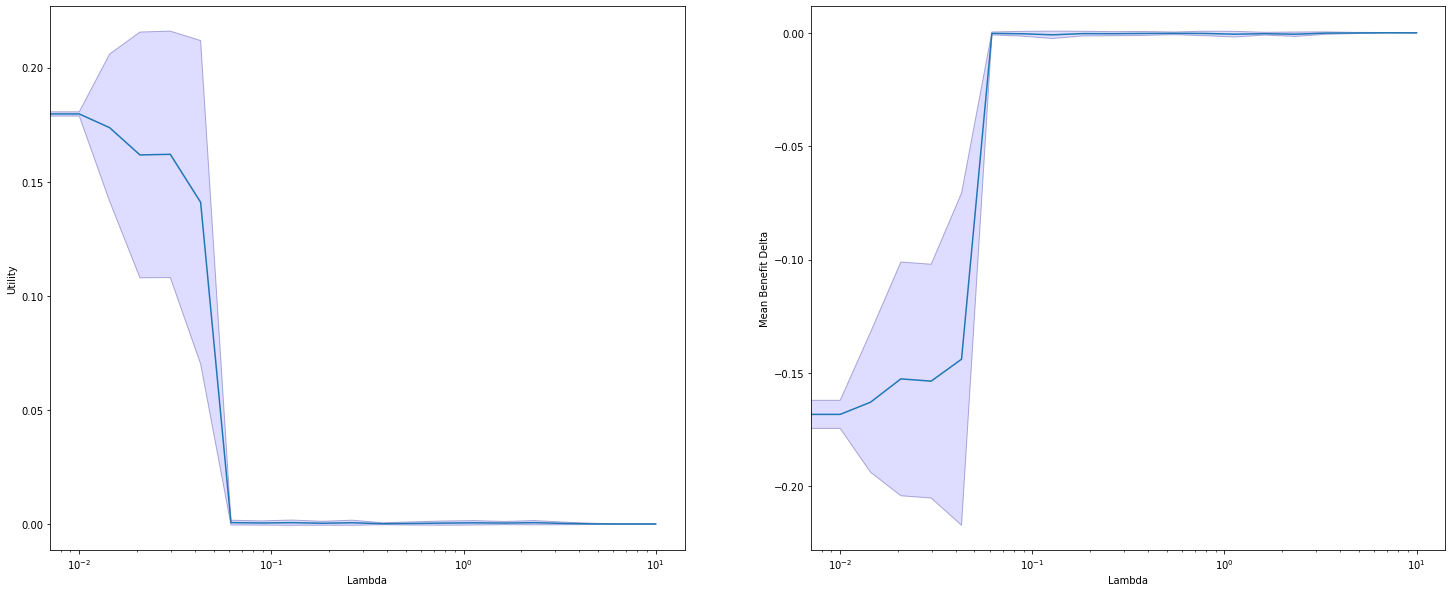

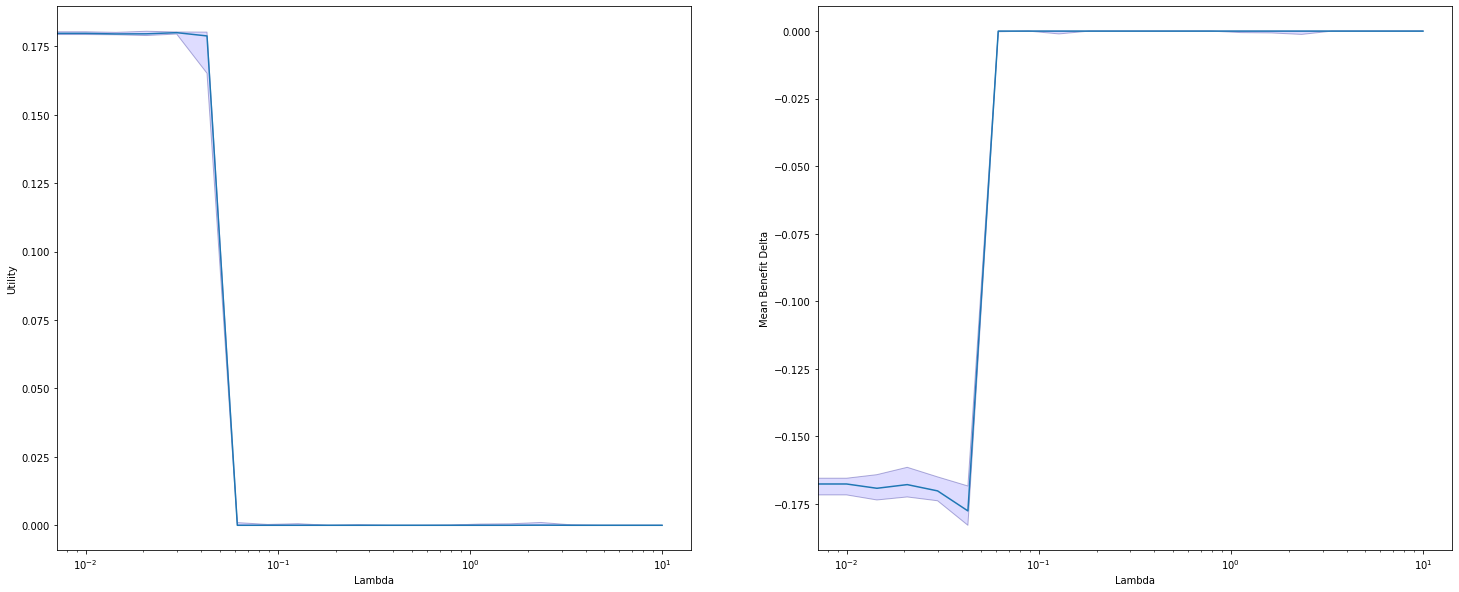

In [5]:
training_parameters["save_path"] = "/home/fkretschmar/Documents/master-thesis/res/exp-008/uncalibrated/lambda"
lambdas = np.logspace(-2, 1, base=10, endpoint=True, num=20)
lambdas = np.insert(arr=lambdas, obj=0, values=[0.0])

statistics, run_path = train(training_parameters, fairness_rates=lambdas, iterations=30, verbose=True, asynchronous=True)

plot_mean_over_lambdas(statistics, "{}/results_mean_lambdas.png".format(run_path))
plot_median_over_lambdas(statistics, "{}/results_median_lambdas.png".format(run_path))

## Split Distribution

In [6]:
bias = True
dim_x = 1
dim_theta = dim_x + 1 if bias else dim_x

def util_func(**util_params):
    util = cost_utility(cost_factor=0.55, **util_params)
    return util

training_parameters = {    
    'model':{
        'theta': [-3.5, 0.6],
        'benefit_value_function': demographic_parity,
        'utility_value_function': util_func,
        'fairness_function': fairness_function,
        'feature_map': IdentityFeatureMap(dim_theta),
        'keep_collected_data': False,
        'use_sensitve_attributes': False,
        'bias': bias
    },
    'optimization': {
        'time_steps':200,
        'epochs': 32,
        'batch_size':512,
        'learning_rate': 0.5,
        'decay_rate': 0.8,
        'decay_step': 30,
        'test_at_every_timestep': False
    },
    'data': {
        'distribution': SplitDistribution(bias=bias),
        'keep_data_across_lambdas': True,
        'fraction_protected':0.5,
        'num_test_samples': 20480,
        'num_decisions': 32 * 512
    }
}

2027689 0.0201937  0.02024351 0.02020171 0.02010192 0.02018744
 0.0201374  0.02022254 0.02016843 0.02018222 0.02015617 0.02021379
 0.02011011 0.02016236 0.02016102 0.02016784 0.02009449 0.02017903
 0.02006323 0.0201483  0.02001881 0.02017751 0.02012669 0.02010405
 0.0201423  0.02014668 0.02013966 0.02015928 0.02017514 0.01998577
 0.02017306 0.02013515 0.0200971  0.02003525 0.02008349 0.0201659
 0.02014223 0.0200968  0.0201287  0.02011957 0.02015462 0.02008332
 0.02016915 0.02014154 0.02004594 0.02012117 0.02006604 0.02008888
 0.02010188 0.02011303 0.02006785 0.01999722 0.02019432 0.02011781
 0.0200421  0.02008825 0.02010831 0.02017242 0.02005846 0.02019734
 0.02014986 0.02019028 0.02003293 0.02009305 0.02005674 0.02006065
 0.02012952 0.02002587 0.02011481 0.02008577 0.02005416 0.0200584
 0.02018409 0.02005968 0.02016895 0.02013589 0.02006255 0.02013937
 0.02011918 0.0199496  0.02011333 0.02011106 0.01999241 0.02008963
 0.02007752 0.02004861 0.02011133 0.02006093 0.02010128 0.01998732
 

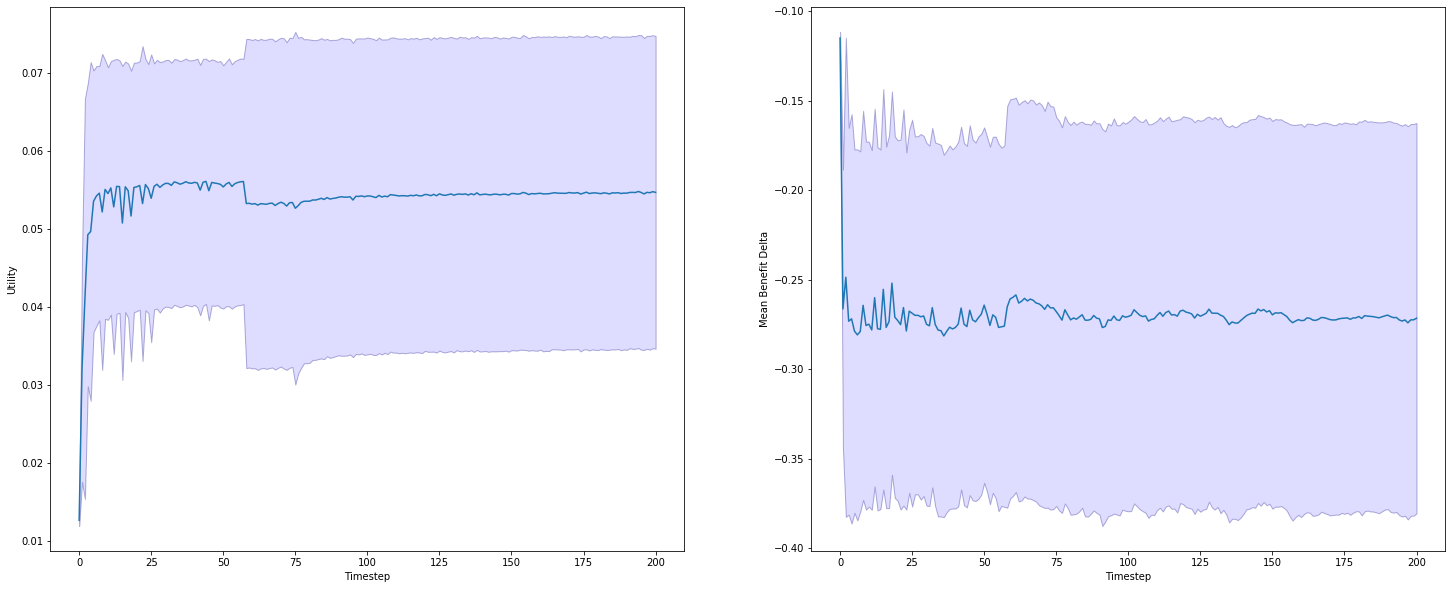

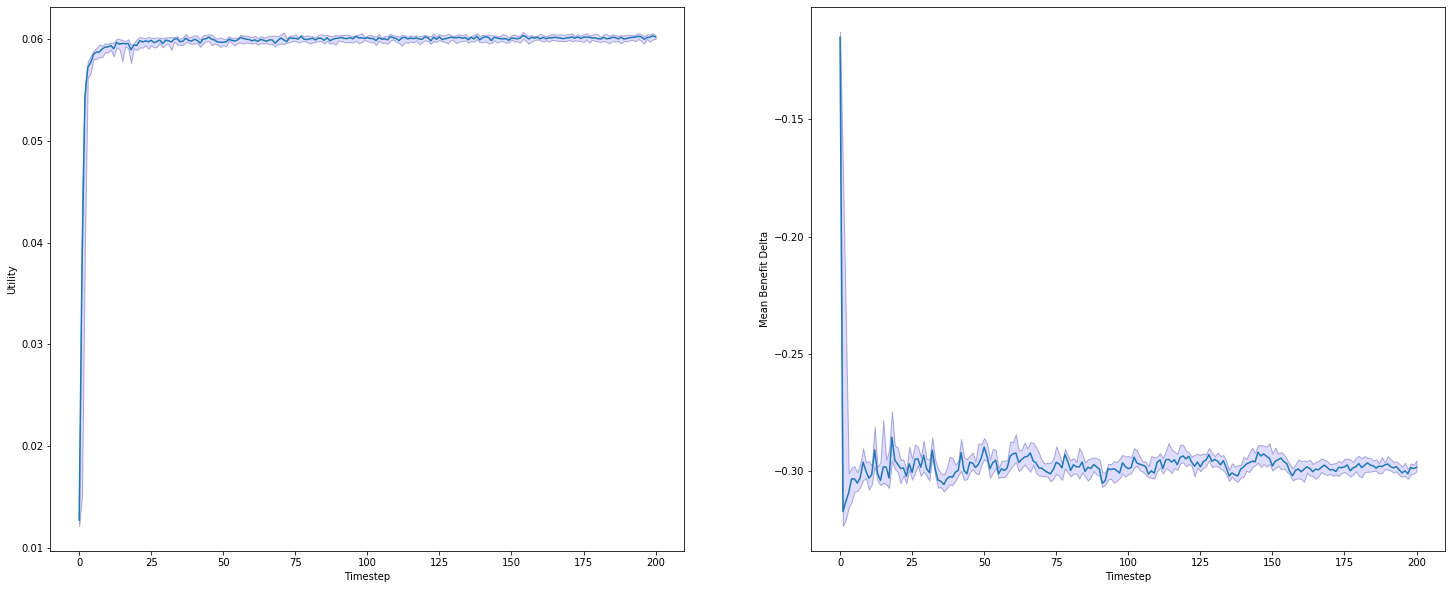

In [7]:
training_parameters["save_path"] = "/home/fkretschmar/Documents/master-thesis/res/exp-008/split/time"
statistics, run_path = train(training_parameters, fairness_rates=[0.0], iterations=30, verbose=True, asynchronous=True)

plot_mean_over_time(statistics, "{}/results_mean.png".format(run_path))
plot_median_over_time(statistics, "{}/results_median.png".format(run_path))

--------------------------------------------------
------------------- Lambda 0.0 -------------------
--------------------------------------------------
------------------- Utility ----------------------
Mean: 0.06245686848958331
Standard deviation: 0.000384798120631446
First quartile: 0.06221496582031248
Median: 0.06251342773437499
Last quartile: 0.06274902343749997
------------------- Benefit Delta ----------------
Mean: -0.30600879437928197
Standard deviation: 0.0026501567428732793
First quartile: -0.307149607641343
Median: -0.3058279863116142
Last quartile: -0.3048470658259247
--------------------------------------------------
------------------- Lambda 0.1 -------------------
--------------------------------------------------
------------------- Utility ----------------------
Mean: 0.00028776041666666414
Standard deviation: 0.022752258649195486
First quartile: -2.0141601562500004e-05
Median: 0.003182373046875
Last quartile: 0.005265502929687501
------------------- Benefit Delta --

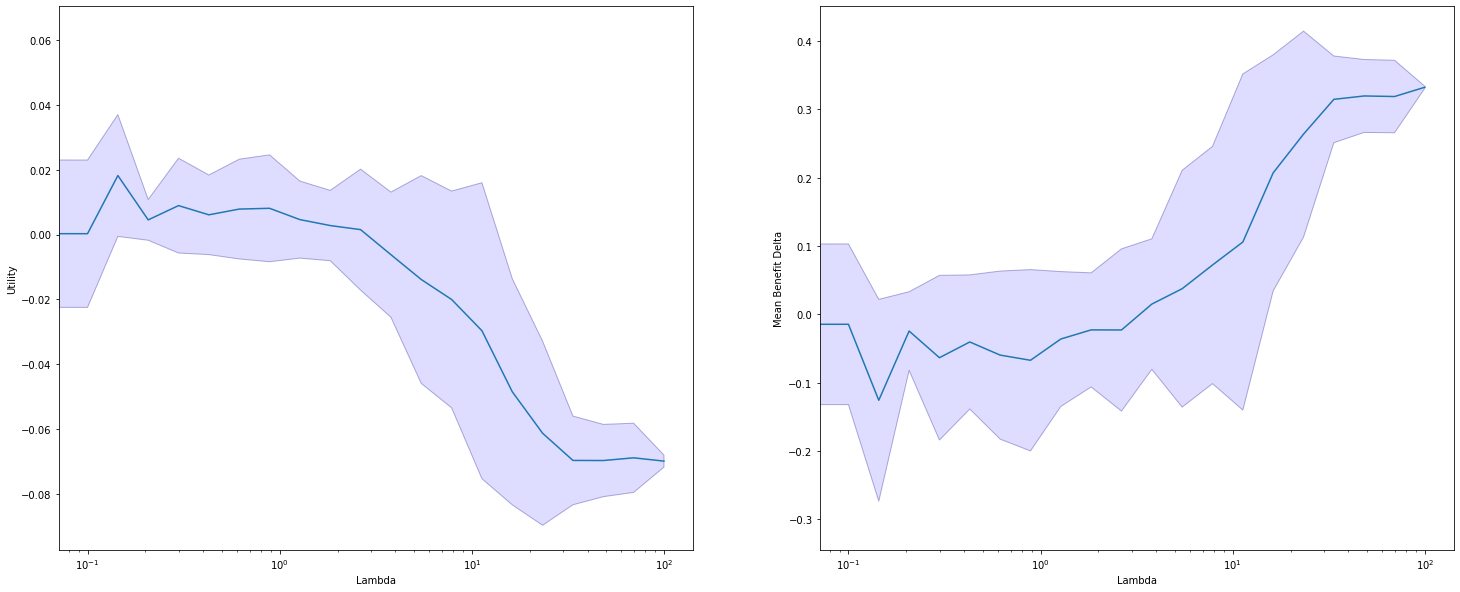

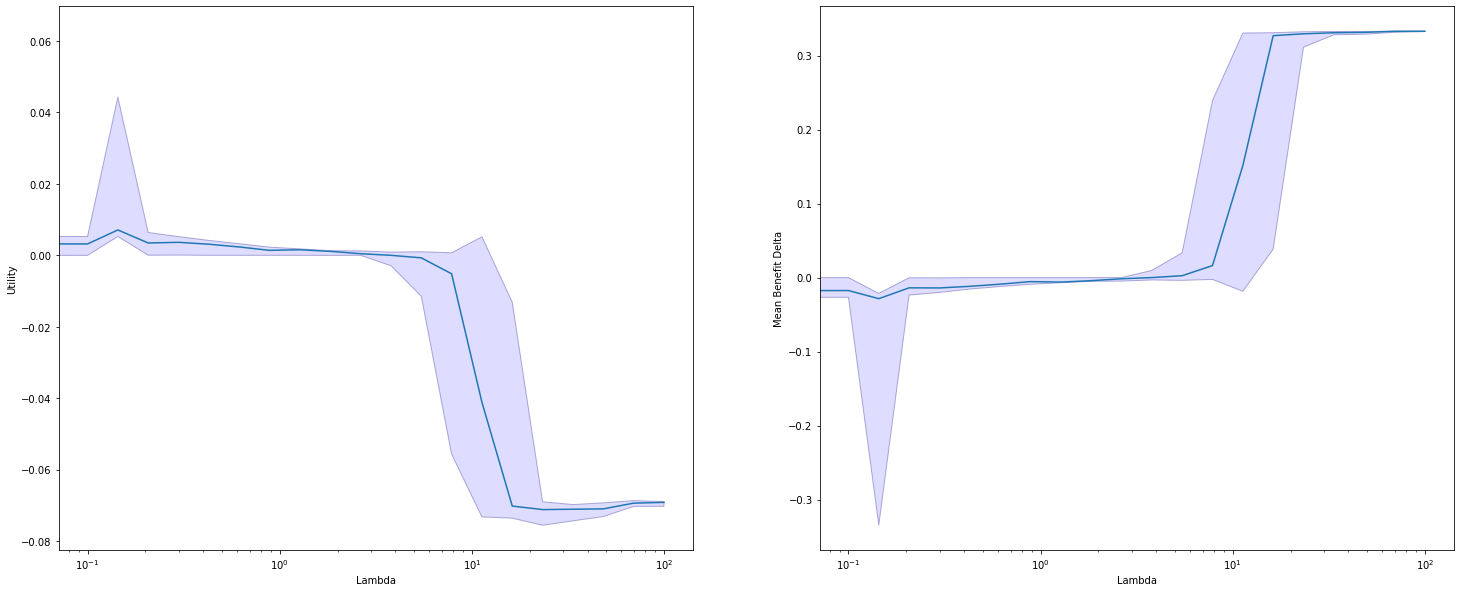

In [8]:
training_parameters["save_path"] = "/home/fkretschmar/Documents/master-thesis/res/exp-008/split/lambda"
lambdas = np.logspace(-1, 2, base=10, endpoint=True, num=20)
lambdas = np.insert(arr=lambdas, obj=0, values=[0.0])

statistics, run_path = train(training_parameters, fairness_rates=lambdas, iterations=30, verbose=True, asynchronous=True)

plot_mean_over_lambdas(statistics, "{}/results_mean_lambdas.png".format(run_path))
plot_median_over_lambdas(statistics, "{}/results_median_lambdas.png".format(run_path))